<a href="https://colab.research.google.com/github/tushar-gupta525/Rainfall-Prediction-Improved-Accuracy-/blob/main/Rainfalll_prediction_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing required Libraries and dependencies
**bold text**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE


In [2]:
data = pd.read_csv("/content/Rainfall.csv")
data.columns = data.columns.str.strip()


In [3]:
data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


In [4]:
# Drop non-informative column
data.drop(columns=["day"], inplace=True)

# Handle missing values
data["winddirection"].fillna(data["winddirection"].mode()[0], inplace=True)
data["windspeed"].fillna(data["windspeed"].median(), inplace=True)

# Encode target
data["rainfall"] = data["rainfall"].map({"yes": 1, "no": 0})


/tmp/ipython-input-1481144359.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["winddirection"].fillna(data["winddirection"].mode()[0], inplace=True)
/tmp/ipython-input-1481144359.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

In [5]:
data["winddir_sin"] = np.sin(np.deg2rad(data["winddirection"]))
data["winddir_cos"] = np.cos(np.deg2rad(data["winddirection"]))
data.drop(columns=["winddirection"], inplace=True)


In [6]:
X = data.drop(columns=["rainfall"])
y = data["rainfall"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: rainfall
1    199
0     93
Name: count, dtype: int64
After SMOTE: rainfall
1    199
0    199
Name: count, dtype: int64


In [8]:
feature_selector = SelectFromModel(
    RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ),
    threshold="median"
)

feature_selector.fit(X_train_res, y_train_res)

X_train_selected = feature_selector.transform(X_train_res)
X_test_selected = feature_selector.transform(X_test)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


In [10]:
param_grid = {
    "n_estimators": [300, 500, 700],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced"]
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train_res)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [11]:
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.71      0.67        24
           1       0.85      0.80      0.82        50

    accuracy                           0.77        74
   macro avg       0.74      0.75      0.75        74
weighted avg       0.78      0.77      0.77        74

ROC-AUC Score: 0.8558333333333333


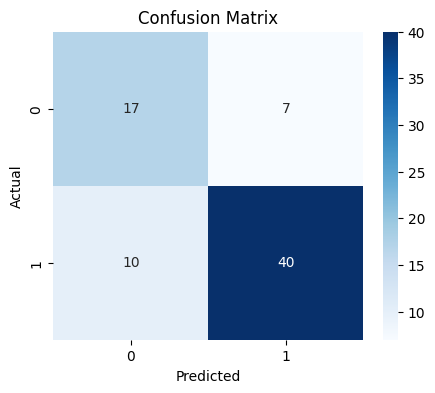

In [12]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [13]:
sample_input = {
    "pressure": 1012.5,
    "maxtemp": 30.2,
    "temparature": 27.8,
    "mintemp": 25.1,
    "dewpoint": 24.3,
    "humidity": 88,
    "cloud": 82,
    "sunshine": 1.2,
    "winddirection": 70,
    "windspeed": 18.5
}


In [14]:
# Convert to DataFrame
input_df = pd.DataFrame([sample_input])

# Encode wind direction
input_df["winddir_sin"] = np.sin(np.deg2rad(input_df["winddirection"]))
input_df["winddir_cos"] = np.cos(np.deg2rad(input_df["winddirection"]))
input_df.drop(columns=["winddirection"], inplace=True)

# Apply same feature selection
input_selected = feature_selector.transform(input_df)

# Scale features
input_scaled = scaler.transform(input_selected)


In [15]:
prediction = best_model.predict(input_scaled)[0]
probability = best_model.predict_proba(input_scaled)[0][1]

result = "YES (Rainfall Expected)" if prediction == 1 else "NO (No Rainfall)"

print("Prediction:", result)
print(f"Probability of Rainfall: {probability:.2f}")


Prediction: YES (Rainfall Expected)
Probability of Rainfall: 0.96


In [17]:
import pickle

model_artifacts = {
    "model": best_model,
    "scaler": scaler,
    "feature_selector": feature_selector,
    "feature_columns": X.columns.tolist()  # original feature order
}

with open("rainfall_model.pkl", "wb") as file:
    pickle.dump(model_artifacts, file)

print("✅ Model saved as rainfall_model.pkl")


✅ Model saved as rainfall_model.pkl


In [18]:
import pickle

with open("rainfall_model.pkl", "rb") as file:
    saved_objects = pickle.load(file)

model = saved_objects["model"]
scaler = saved_objects["scaler"]
feature_selector = saved_objects["feature_selector"]
feature_columns = saved_objects["feature_columns"]

print("✅ Model loaded successfully")


✅ Model loaded successfully


In [19]:
import numpy as np
import pandas as pd

def predict_rainfall(input_data: dict):
    """
    input_data: dictionary of weather features
    returns: prediction label and probability
    """

    # Convert input to DataFrame
    df = pd.DataFrame([input_data])

    # Wind direction cyclic encoding
    df["winddir_sin"] = np.sin(np.deg2rad(df["winddirection"]))
    df["winddir_cos"] = np.cos(np.deg2rad(df["winddirection"]))
    df.drop(columns=["winddirection"], inplace=True)

    # Ensure correct feature order
    df = df[feature_columns]

    # Feature selection
    df_selected = feature_selector.transform(df)

    # Scaling
    df_scaled = scaler.transform(df_selected)

    # Prediction
    pred = model.predict(df_scaled)[0]
    prob = model.predict_proba(df_scaled)[0][1]

    label = "YES (Rainfall Expected)" if pred == 1 else "NO (No Rainfall)"

    return label, round(prob, 3)


In [20]:
sample_input = {
    "pressure": 1012.5,
    "maxtemp": 30.2,
    "temparature": 27.8,
    "mintemp": 25.1,
    "dewpoint": 24.3,
    "humidity": 88,
    "cloud": 82,
    "sunshine": 1.2,
    "winddirection": 70,
    "windspeed": 18.5
}

prediction, probability = predict_rainfall(sample_input)

print("Prediction:", prediction)
print("Rainfall Probability:", probability)


Prediction: YES (Rainfall Expected)
Rainfall Probability: 0.957


In [21]:
# -----------------------------
# Batch Rainfall Predictions
# -----------------------------

test_inputs = [
    {
        "name": "Heavy Rain",
        "pressure": 1004.2,
        "maxtemp": 28.1,
        "temparature": 25.6,
        "mintemp": 24.9,
        "dewpoint": 24.3,
        "humidity": 94,
        "cloud": 92,
        "sunshine": 0.2,
        "winddirection": 210,
        "windspeed": 22.4
    },
    {
        "name": "Light Rain",
        "pressure": 1009.8,
        "maxtemp": 30.4,
        "temparature": 27.9,
        "mintemp": 25.8,
        "dewpoint": 23.1,
        "humidity": 86,
        "cloud": 78,
        "sunshine": 1.5,
        "winddirection": 140,
        "windspeed": 18.0
    },
    {
        "name": "Clear Weather",
        "pressure": 1021.5,
        "maxtemp": 34.6,
        "temparature": 32.1,
        "mintemp": 30.2,
        "dewpoint": 19.2,
        "humidity": 55,
        "cloud": 18,
        "sunshine": 10.8,
        "winddirection": 60,
        "windspeed": 9.4
    },
    {
        "name": "Borderline Case",
        "pressure": 1014.3,
        "maxtemp": 31.0,
        "temparature": 28.7,
        "mintemp": 26.4,
        "dewpoint": 22.5,
        "humidity": 74,
        "cloud": 55,
        "sunshine": 4.0,
        "winddirection": 95,
        "windspeed": 14.2
    },
    {
        "name": "Windy but Dry",
        "pressure": 1019.6,
        "maxtemp": 33.2,
        "temparature": 30.9,
        "mintemp": 28.3,
        "dewpoint": 20.1,
        "humidity": 62,
        "cloud": 25,
        "sunshine": 8.6,
        "winddirection": 320,
        "windspeed": 32.0
    }
]

print("🌧️ Rainfall Prediction Results\n")

for sample in test_inputs:
    name = sample.pop("name")
    prediction, probability = predict_rainfall(sample)
    print(f"{name:15s} → {prediction}, Probability = {probability}")


🌧️ Rainfall Prediction Results

Heavy Rain      → YES (Rainfall Expected), Probability = 0.993
Light Rain      → YES (Rainfall Expected), Probability = 0.91
Clear Weather   → NO (No Rainfall), Probability = 0.01
Borderline Case → NO (No Rainfall), Probability = 0.333
Windy but Dry   → NO (No Rainfall), Probability = 0.17
